In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerPathCollection
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import math
import time

np.random.seed(0)
agents = 100
n = 500
n_test = 2000
classify_times = []
accuracies = []
truths = np.array([-1] * int(n_test * 0.05) + [1] * int(n_test * (1 - 0.05)))
truths

array([-1, -1, -1, ...,  1,  1,  1])

# Data Generation

In [95]:
def truncated_normal(n, minval=0, maxval=1):
    return np.clip(np.random.normal(0.85, 0.05, (n, agents)), minval, maxval)


def linear(n):
    data = []
    for _ in range(agents):
        data.append(np.linspace(0.20, 0.92, n) + np.random.normal(-0.05, 0.05, n))
    return np.array(data).T

def sinusoidal(n):
    x = np.linspace(0, 1, n)

    datasets = [x]
    
    for _ in range(agents-1):
        noise = np.random.normal(scale=0.07, size=n)
        dataset = [0.5 + 0.2 * math.sin(2 * math.pi * i / n) for i in range(n)]
        dataset += noise  # Add noise to dataset
        datasets.append(dataset)
    
    # Combine datasets into a num_points x dimension array
    combined_dataset = np.vstack(datasets).T
    return combined_dataset

def gen_outliers(n, finlier):
    cluster_points = finlier(n)
    outliers = []
    while len(outliers) < n:
        point = np.random.rand(agents)
        distances = np.linalg.norm(cluster_points - point, axis=1)
        if np.all(distances > 0.05):  # Adjust threshold as needed
            outliers.append(point)
    return np.array(outliers)

def generate_test_data(n, finlier, contamination):
    n_outliers = int(n * contamination)
    n_inliers = n - n_outliers
    outliers = gen_outliers(n_outliers, finlier)
    inliers = finlier(n_inliers)
    return np.vstack((outliers, inliers))

def generate_patient_vital_signs(n):
    train_data = truncated_normal(n)
    test_data = generate_test_data(n_test, truncated_normal, 0.05)    

    return train_data, test_data

def generate_traffic_flow(n):
    train_data = linear(n)
    test_data = generate_test_data(n_test, linear, 0.05)

    return train_data, test_data

def generate_political_influence(n):
    train_data = sinusoidal(n)
    test_data = generate_test_data(n_test, sinusoidal, 0.05)
    return train_data, test_data
    


In [96]:
 def gen_data():  
    print("Generating data...")
    health_data, health_test = generate_patient_vital_signs(n)
    traffic_data, traffic_test = generate_traffic_flow(n)
    political_data, political_test = generate_political_influence(n)
    
    train_data = [health_data, traffic_data, political_data]
    test_data = [health_test, traffic_test, political_test]
    return train_data,test_data

health_data, health_test = generate_patient_vital_signs(n)
np.savetxt("test/test1.csv", np.array(health_test), delimiter=',')
np.savetxt("train/train1.csv", health_data, delimiter=',')
traffic_data, traffic_test = generate_traffic_flow(n)
np.savetxt("test/test2.csv", health_test, delimiter=',')
np.savetxt("train/train2.csv", health_data, delimiter=',')
political_data, political_test = generate_political_influence(n)
np.savetxt("test/test3.csv", health_test, delimiter=',')
np.savetxt("train/train3.csv", health_data, delimiter=',')
train_data = [health_data, traffic_data, political_data]
test_data = [health_test, traffic_test, political_test]

# Visualization

In [97]:
def visualize(data, pred=None): 
    if pred is not None:
        tp = (pred == 1) & (truths == 1)
        tn = (pred == -1) & (truths == -1)
        fp = (pred == 1) & (truths == -1)
        fn = (pred == -1) & (truths == 1)
        
        plt.scatter(data[tp,0], data[tp,1], color='blue', label='TP')
        plt.scatter(data[tn,0], data[tn,1], color='red', label='TN')
        plt.scatter(data[fp,0], data[fp,1], color='red', marker='x', label='FP')
        plt.scatter(data[fn,0], data[fn,1], color='blue', marker='x', label='FN')
        
        plt.title('model classification results')
  
    else:
        plt.scatter(data[:,0], data[:,1])
        plt.scatter(data[:,0], data[:,1])
        plt.title('training data')
        
    plt.xlabel('agent 1')
    plt.ylabel('agent 2')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.legend(loc="upper left")
    plt.show()
        
 
def predict_and_time(model, test):
    time_start = time.time()
    pred = model.predict(test)
    time_end = time.time()
    classify_times.append((model.__class__.__name__, time_end-time_start))
    errors = (pred != truths).sum()
    accuracy = (n_test - errors) / n_test
    accuracies.append((model.__class__.__name__, accuracy))
    return pred
        

# Modeling

In [98]:
def run_models(model, cluster=False, vis=True, ag=agents):
    train_data,test_data = gen_data()
    print(np.array(train_data).shape)
    print("Running model...")
    for data in zip(train_data, test_data):
        if cluster:
            clf = model.fit(data[1], truths)
        else:
            clf = model.fit(data[0])
        pred = predict_and_time(clf, data[1])
        if vis: visualize(data[1], pred)


# Local Outlier Factor

Generating data...
(3, 500, 100)
Running model...


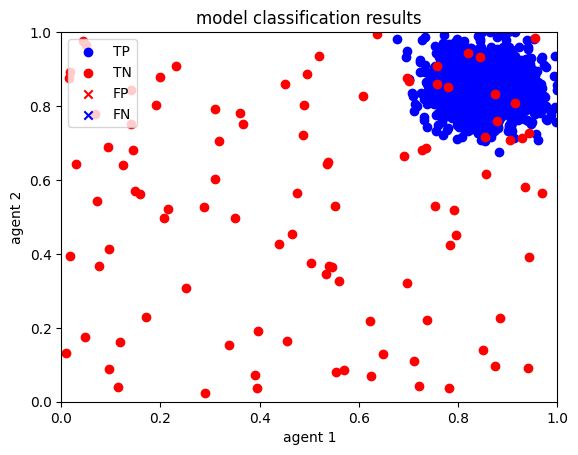

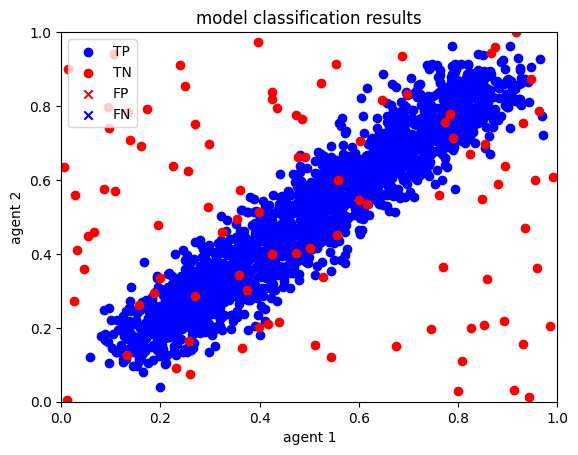

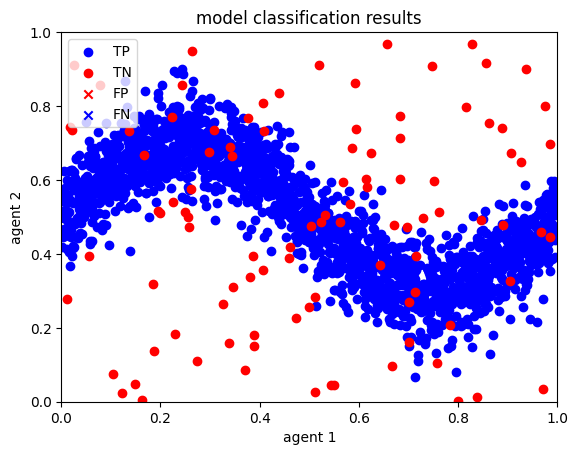

'\nX_scores = lof.negative_outlier_factor_\nradius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())\n\nscatter = plt.scatter(\n    health_data[:,0],\n    health_data[:,1],\n    s=1000*radius,\n    edgecolors="r",\n    facecolors="none",\n    label="Outlier scores"\n)\n'

In [99]:
lof = LocalOutlierFactor(n_neighbors=10, novelty=True)

run_models(lof)

'''
X_scores = lof.negative_outlier_factor_
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

scatter = plt.scatter(
    health_data[:,0],
    health_data[:,1],
    s=1000*radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores"
)
'''

# One Class SVM 

Generating data...
(3, 500, 100)
Running model...


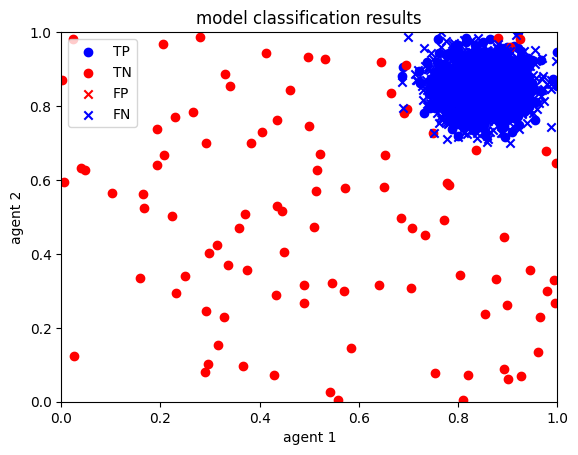

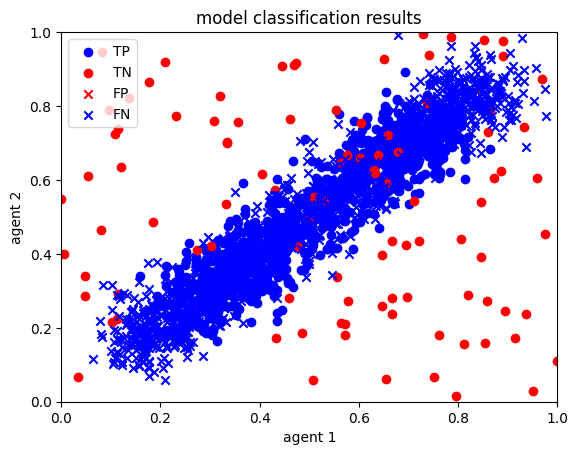

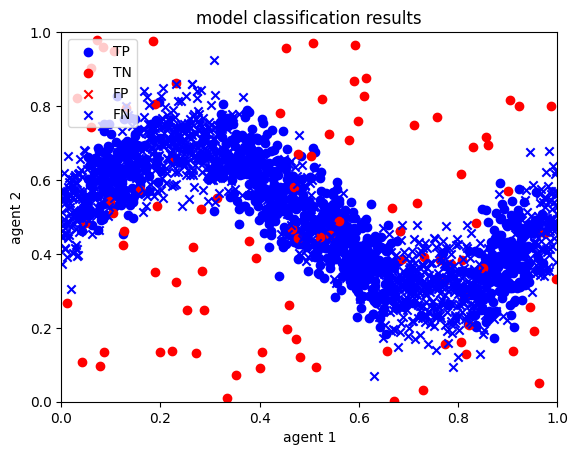

'\nclassify_times.append(("SVM", end_time - start_time))\nh = 0.02\nx_min, x_max = health_data[:,0].min() - 1, health_data[:,1].max() + 1\ny_min, y_max = health_data[:,1].min() - 1, health_data[:,1].max() + 1\nxx, yy = np.meshgrid(np.arange(x_min, x_max, h),\n                     np.arange(y_min, y_max, h))\nZ_linear = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])\nZ_linear = Z_linear.reshape(xx.shape)\nplt.contourf(xx, yy, Z_linear, cmap=plt.cm.PuBu, alpha=0.8)\nZ_linear = Z_linear.reshape(xx.shape)\n'

In [100]:
clf = OneClassSVM()
run_models(clf)

'''
classify_times.append(("SVM", end_time - start_time))
h = 0.02
x_min, x_max = health_data[:,0].min() - 1, health_data[:,1].max() + 1
y_min, y_max = health_data[:,1].min() - 1, health_data[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z_linear = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z_linear = Z_linear.reshape(xx.shape)
plt.contourf(xx, yy, Z_linear, cmap=plt.cm.PuBu, alpha=0.8)
Z_linear = Z_linear.reshape(xx.shape)
'''

# Isolation Forest

Generating data...
(3, 500, 100)
Running model...


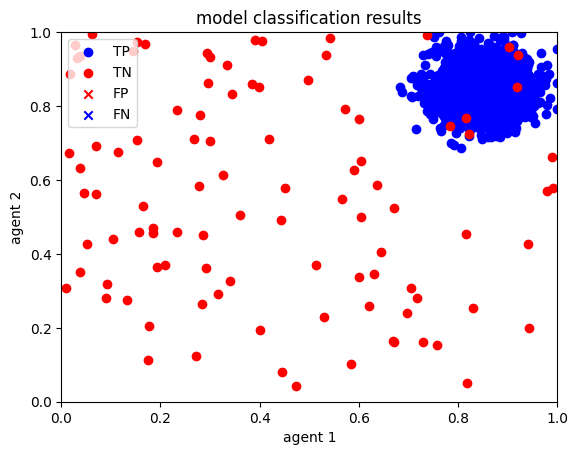

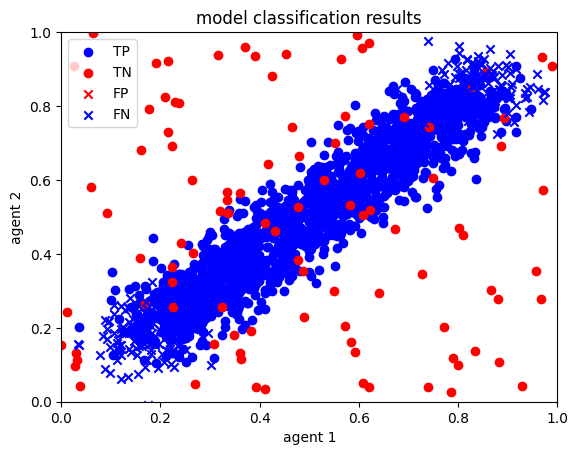

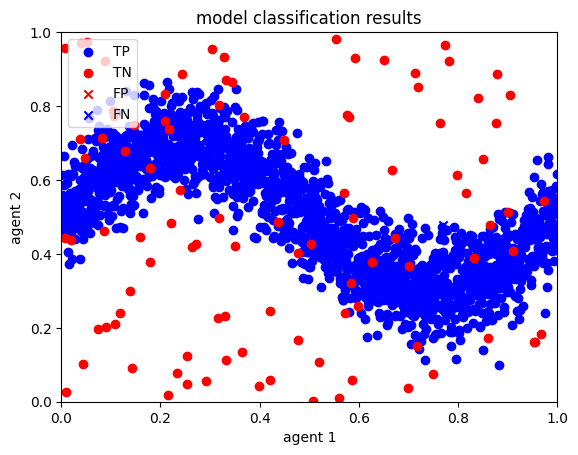

'\nh = 0.02\nx_min, x_max = health_data[:,0].min() - 1, health_data[:,1].max() + 1\ny_min, y_max = health_data[:,1].min() - 1, health_data[:,1].max() + 1\nxx, yy = np.meshgrid(np.arange(x_min, x_max, h),\n                     np.arange(y_min, y_max, h))\nZ_linear = clf.predict(np.c_[xx.ravel(), yy.ravel()])\nZ_linear = Z_linear.reshape(xx.shape)\n\ndisp = DecisionBoundaryDisplay(\n    xx0 = xx,\n    xx1 = yy,\n    response = Z_linear\n)\ndisp.plot()\n'

In [101]:
clf = IsolationForest(random_state=0)
run_models(clf)

'''
h = 0.02
x_min, x_max = health_data[:,0].min() - 1, health_data[:,1].max() + 1
y_min, y_max = health_data[:,1].min() - 1, health_data[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z_linear = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z_linear = Z_linear.reshape(xx.shape)

disp = DecisionBoundaryDisplay(
    xx0 = xx,
    xx1 = yy,
    response = Z_linear
)
disp.plot()
'''


# K Neighbors 

Generating data...
(3, 500, 100)
Running model...


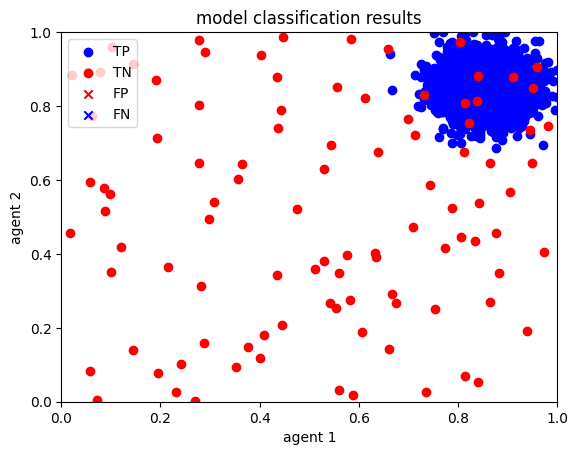

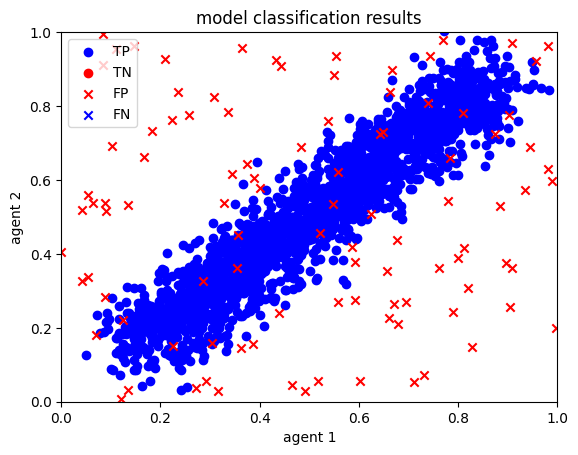

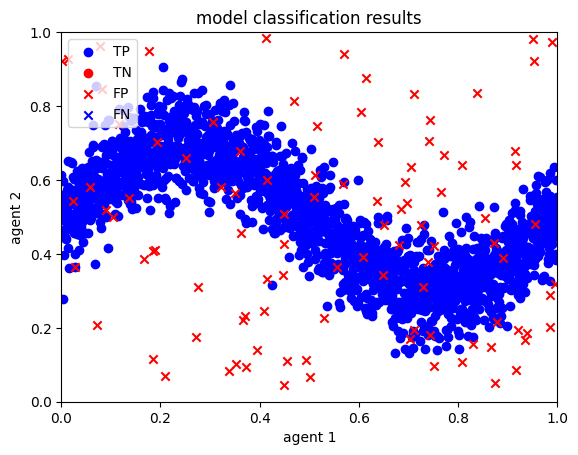

"\nh = 0.02\nx_min, x_max = health_data[:,0].min() - 1, health_data[:,1].max() + 1\ny_min, y_max = health_data[:,1].min() - 1, health_data[:,1].max() + 1\nxx, yy = np.meshgrid(np.arange(x_min, x_max, h),\n                     np.arange(y_min, y_max, h))\n\nZ_linear = clf.predict(np.c_[xx.ravel(), yy.ravel()])\nZ_linear = Z_linear.reshape(xx.shape)\ncmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])\nplt.pcolormesh(xx, yy, Z_linear, cmap=cmap_light)\n"

In [102]:
clf = KNeighborsClassifier(5)
run_models(clf, cluster=True)
'''
h = 0.02
x_min, x_max = health_data[:,0].min() - 1, health_data[:,1].max() + 1
y_min, y_max = health_data[:,1].min() - 1, health_data[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z_linear = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z_linear = Z_linear.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
plt.pcolormesh(xx, yy, Z_linear, cmap=cmap_light)
'''



# DBSCAN

eps:  0.1


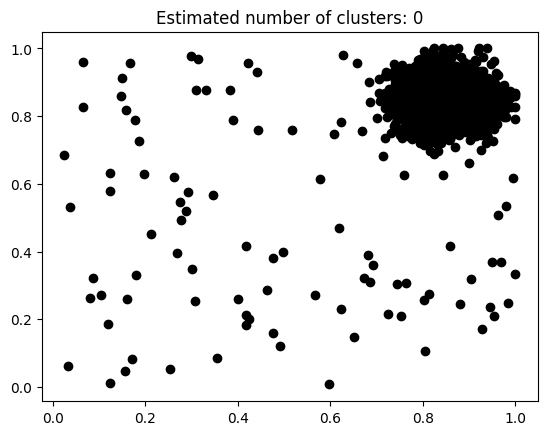

eps:  0.2


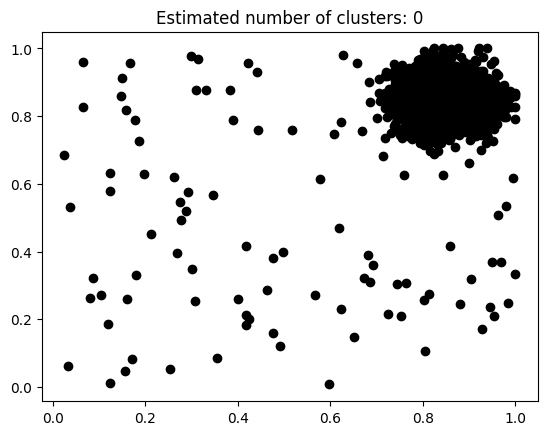

eps:  0.30000000000000004


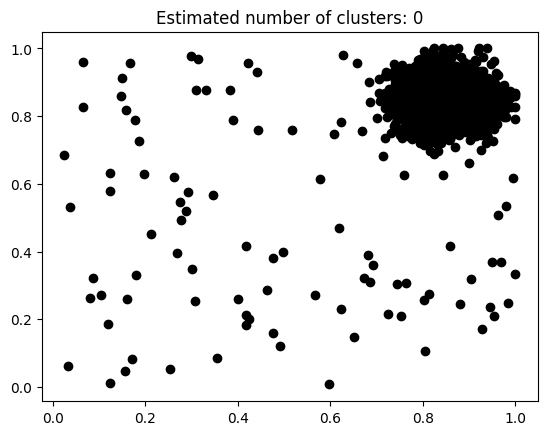

eps:  0.4


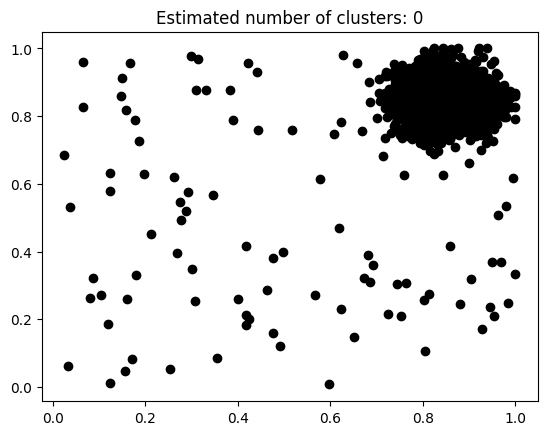

eps:  0.5


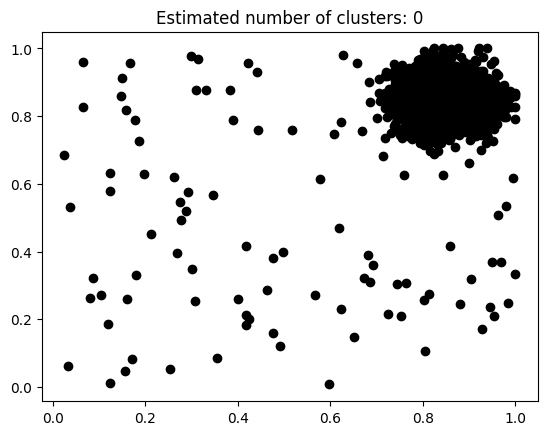

In [103]:
health_data_all = np.vstack((health_data, health_test))
for i in np.linspace(0.1,0.5,5):
    print("eps: ", i)
    clustering = DBSCAN(eps=i, min_samples=20).fit(health_data_all)
    labels = clustering.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[clustering.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = health_data_all[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = health_data_all[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title(f"Estimated number of clusters: {n_clusters_}")
    plt.show()

# Performance Analysis

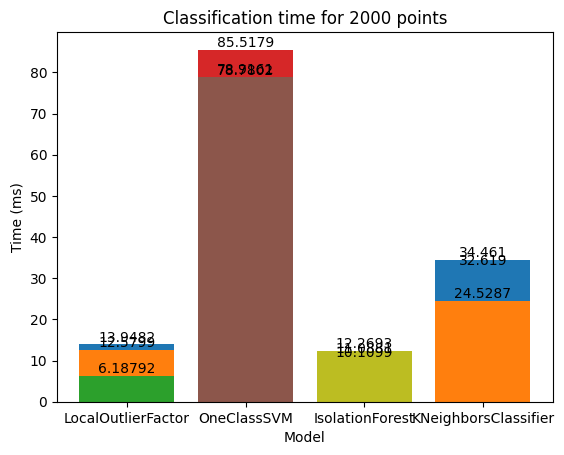

In [104]:
fig,ax = plt.subplots()
for times in classify_times:
    p = ax.bar(times[0], times[1]*1000)
    ax.bar_label(p, label_type='edge')
    
plt.title("Classification time for " + str(n_test) +" points")
plt.ylabel("Time (ms)")
plt.xlabel("Model")
plt.show()

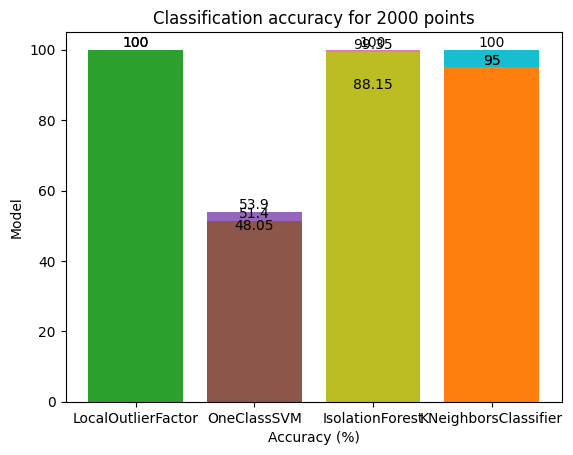

In [105]:
fig,ax = plt.subplots()
for accuracy in accuracies:
    p = ax.bar(accuracy[0], accuracy[1]*100)
    ax.bar_label(p)
    
plt.title("Classification accuracy for " + str(n_test) +" points")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.show()

In [106]:
for i in range(2, 300):
    print("num agents: ", agents)
    classify_times = []
    agents=i
    lof = LocalOutlierFactor(novelty=True)
    run_models(clf, vis=False)
    print(classify_times)
    plt.scatter(i, classify_times[2][1]*1000, color="blue")

num agents:  100
Generating data...
(3, 500, 2)
Running model...


TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
for i in range(2, 300):
    print("num agents: ", agents)
    classify_times = []
    agents=i
    clf = OneClassSVM()
    run_models(clf, vis=False)
    print(classify_times)
    plt.scatter(i, classify_times[2][1]*1000, color="blue")

In [ ]:
for i in range(2, 300):
    print("num agents: ", agents)
    classify_times = []
    agents = i
    clf = IsolationForest(random_state=0)
    run_models(clf, vis=False)
    print(classify_times)
    plt.scatter(i, classify_times[2][1] * 1000, color="blue")

In [ ]:
for i in range(2, 300):
    print("num agents: ", agents)
    classify_times = []
    agents=i
    clf = KNeighborsClassifier(5)
    run_models(clf, vis=False)
    print(classify_times)
    plt.scatter(i, classify_times[2][1]*1000, color="blue")